* [1 Uncertainty Model](#UncertaintyModel)
    * [Cross-validation](#1CrossValidation)
    * [AR Parameter Optimization](#1ARParameterOptimization)
    * [Uncertainty Model](#1UncertaintyModel)
* [2 Decision Making and Evaluation](#2DecisionMakingEvaluation)

* [3 Initial Asset and feasibility Analysis]()

In [1]:
import numpy as np
from cvxpy import *
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [2]:
# load data.
beta = np.loadtxt("projectdata.txt")
# load test data.
test_data = np.loadtxt("test_data.txt")
more_test_data = np.genfromtxt("more_test_data.txt", delimiter=',')

# 1 Uncertainty Model <a id="UncertaintyModel"></a>

## Cross-validation<a id="1CrossValidation"></a>

In [3]:
def uncertainty_model_cv(beta, p):
    n = len(beta)
    # create the H matrix, split the traning and validation set
    H_all = np.zeros(p*n).reshape(n, p)
    for i in np.arange(p):
        H_all[:,i] = np.concatenate([np.zeros(i+1), beta[:-(i+1)]])
    beta_validation = beta[-6:]
    H_p = H_all[p:-6, :]
    H_validation = H_all[-6:, :]
    beta_p = beta[p:-6]
    # solve the optimization problem
    sigma_hat = Variable(1)
    theta_hat = Variable(p)
    prob = Problem(Minimize(sigma_hat), 
                   [norm(beta_p - H_p*theta_hat, "inf") <= sigma_hat,
                    sigma_hat > 0])
    prob.solve()
    # calculate the error
    error = H_validation.dot(np.array(theta_hat.value)).flatten()-\
    beta_validation
    # calculate the mean absolute error
    mae = sum(np.abs(error))/6
    n_excess_bound = sum(np.abs(error)-sigma_hat.value > 0)
    return sigma_hat.value, theta_hat.value, mae, n_excess_bound

In [4]:
maes = []
n_excess_bounds = []
for p in np.arange(1, 31):
    theta_hats_cv = []
    maes_cv = []
    n_excess_bounds_cv = []
    for cv in np.arange(10):
        if cv == 0:
            sigma_hat, theta_hat, mae, n_excess_bound = \
            uncertainty_model_cv(beta,p)
        else:
            sigma_hat, theta_hat, mae, n_excess_bound = \
            uncertainty_model_cv(beta[:-cv],p)
        maes_cv += [mae]
        n_excess_bounds_cv += [n_excess_bound]
    maes += [np.mean(maes_cv)]
    n_excess_bounds += [np.mean(n_excess_bounds_cv)/6]

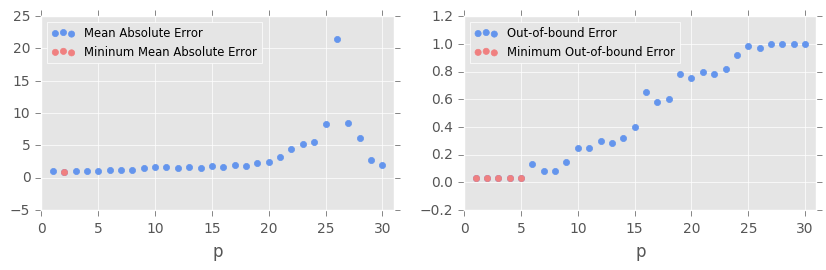

In [5]:
f, axarr = plt.subplots(1, 2, figsize=(10,2.5))
axarr[0].scatter(np.arange(1, 31), maes, 
                 label="Mean Absolute Error", 
                 color = "cornflowerblue")
axarr[0].scatter(np.arange(1, 31)[1], maes[1], 
                 color = "lightcoral", 
                 label="Mininum Mean Absolute Error")
axarr[0].legend(loc="upper left", fontsize = 'x-small')
axarr[0].set_xlim([0, 31])
axarr[0].legend(loc="upper left", fontsize = 'small')
axarr[0].set_xlabel('p')
axarr[1].scatter(np.arange(1, 31), n_excess_bounds, 
                 label="Out-of-bound Error", 
                 color = "cornflowerblue")
axarr[1].scatter(np.arange(1, 31)[:5], n_excess_bounds[:5], 
                 color = "lightcoral",
                 label="Minimum Out-of-bound Error")
axarr[1].set_xlim([0, 31])
axarr[1].legend(loc="upper left", fontsize = 'small')
axarr[1].set_xlabel('p')
f.savefig("report/cv.png")

## AR Parameter Optimization<a id="1ARParameterOptimization"></a>

We choose p=2 to fit our model.

In [6]:
def ar_opt(beta, p, return_beta_hat = False):
    n = len(beta)
    # create the H matrix
    H_p = np.zeros(p*n).reshape(n, p)
    for i in np.arange(p):
        H_p[:,i] = np.concatenate([np.zeros(i+1), beta[:-(i+1)]])
    beta_validation = beta[-6:]
    H_p = H_p[p:, :]
    beta_p = beta[p:]
    # solve the optimization problem
    sigma_hat = Variable(1)
    theta_hat = Variable(p)
    prob = Problem(Minimize(sigma_hat), 
                   [norm(beta_p - H_p*theta_hat, "inf") <= sigma_hat,
                    sigma_hat > 0])
    prob.solve()
    if (return_beta_hat):
        return [sigma_hat.value, np.asarray(theta_hat.value).flatten(), 
                np.asarray(H_p*theta_hat.value).flatten()]
    return [sigma_hat.value, np.asarray(theta_hat.value).flatten()]

In [7]:
sigma, theta, beta_hat = ar_opt(beta = beta, p = 2, return_beta_hat = True)

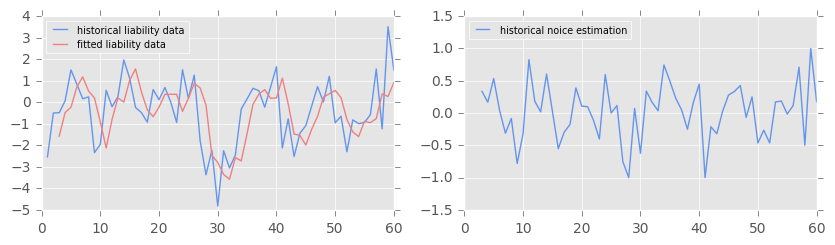

In [8]:
f, axarr = plt.subplots(1, 2, figsize=(10,2.5))
axarr[0].plot(np.arange(1, 61), beta, 
                 label="historical liability data", 
                 color = "cornflowerblue")
axarr[0].plot(np.arange(1 + 2, 61), beta_hat, 
                 label="fitted liability data", 
                 color = "lightcoral")
axarr[0].legend(loc="upper left", fontsize = 'x-small')
axarr[1].plot(np.arange(1 + 2, 61), (beta[2:]-beta_hat)/sigma, 
                 label="historical noice estimation", 
                 color = "cornflowerblue")
axarr[1].legend(loc="upper left", fontsize = 'x-small')

## Uncertainty Model<a id="1UncertaintyModel"></a>

In [9]:
def calc_beta_hat_B(sigma, theta, beta):
    theta_1 = theta[0]
    theta_2 = theta[1]
    beta_t_1 = beta[-2]
    beta_t = beta[-1]
    beta_t1 = np.array([theta_1, theta_2, sigma])
    beta_t2 = theta_1*np.concatenate([beta_t1, [0]]) + \
        theta_2*np.array([1, 0, 0, 0]) + \
        sigma*np.array([0, 0, 0, 1])
    beta_t3 = theta_1*np.concatenate([beta_t2, [0]]) + \
        theta_2*np.concatenate([beta_t1, [0, 0]]) + \
        sigma*np.array([0, 0, 0, 0, 1])
    beta_t4 = theta_1*np.concatenate([beta_t3, [0]]) + \
        theta_2*np.concatenate([beta_t2, [0, 0]]) + \
        sigma*np.array([0, 0, 0, 0, 0, 1])
    beta_t5 = theta_1*np.concatenate([beta_t4, [0]]) + \
        theta_2*np.concatenate([beta_t3, [0, 0]]) + \
        sigma*np.array([0, 0, 0, 0, 0, 0, 1])
    beta_t6 = theta_1*np.concatenate([beta_t5, [0]]) + \
        theta_2*np.concatenate([beta_t4, [0, 0]]) + \
        sigma*np.array([0, 0, 0, 0, 0, 0, 0, 1])
        
    b_hat = np.vstack([beta_t1[:2], beta_t2[:2], beta_t3[:2], 
                       beta_t4[:2], beta_t5[:2], beta_t6[:2]]).dot(
        np.array([beta_t, beta_t_1]))
    B = np.vstack([np.concatenate([beta_t1[2:], np.zeros(5)]),
                  np.concatenate([beta_t2[2:], np.zeros(4)]),
                  np.concatenate([beta_t3[2:], np.zeros(3)]),
                  np.concatenate([beta_t4[2:], np.zeros(2)]),
                  np.concatenate([beta_t5[2:], np.zeros(1)]),
                  beta_t6[2:]])
    return b_hat.reshape(6, 1), B

In [10]:
b_hat, B = calc_beta_hat_B(sigma, theta, beta)

In [11]:
b_hat

array([[ 2.53868639],
       [ 1.93268543],
       [ 2.22029883],
       [ 2.02661616],
       [ 2.09286371],
       [ 2.0194315 ]])

In [12]:
B

array([[ 3.24341243,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.45644363,  3.24341243,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 2.38187229,  1.45644363,  3.24341243,  0.        ,  0.        ,
         0.        ],
       [ 1.84546219,  2.38187229,  1.45644363,  3.24341243,  0.        ,
         0.        ],
       [ 2.09759205,  1.84546219,  2.38187229,  1.45644363,  3.24341243,
         0.        ],
       [ 1.9250487 ,  2.09759205,  1.84546219,  2.38187229,  1.45644363,
         3.24341243]])

# 2 Decision Making and Metrics<a id="2DecisionMakingEvaluation"></a>

In [13]:
A = np.array([[  -1.,     0,     0,     0,     0,  0,    1.,     0,     0,    1.,     0,     0,     0,     0],
              [1.003,    -1,     0,     0,     0,  0,     0,    1.,     0, -1.01,    1.,     0,     0,     0],
              [    0, 1.003,    -1,     0,     0,  0,     0,     0,    1.,     0, -1.01,    1.,     0,     0],
              [    0,     0, 1.003,    -1,     0,  0, -1.02,     0,     0,     0,     0, -1.01,    1.,     0],
              [    0,     0,     0, 1.003,    -1,  0,     0, -1.02,     0,     0,     0,     0, -1.01,    1.],
              [    0,     0,     0,     0, 1.003, -1,     0,     0, -1.02,     0,     0,     0,     0, -1.01]])

## Naive Strategy

In [14]:
def naive_strategy_jan(C_initial):
    C_initial_array = np.array([C_initial, 0, 0, 0, 0, 0]).reshape(6, 1)
    x_cash = Variable(6, 1)
    x_cp = Variable(3, 1)
    x_cre = Variable(5, 1)
    prob = Problem(Maximize(x_cash[5]), 
               [A*vstack(x_cash, x_cp, x_cre) + C_initial_array >= b_hat,
                x_cre <= 1, x_cre >=0, x_cp >= 0, x_cash >= 0])
    prob.solve()
    return x_cash.value, x_cp.value, x_cre.value

In [36]:
def naive_strategy(C_initial, b_hat, month, 
                   x_cash_previous, x_cp_previous, x_cre_previous):
    
    month_remaining = 6-month
    
    # we have already applied the strategy to the previous i-1 month 
    x_cash_previous = x_cash_previous[:(month-1), :] 
    x_cp_previous = x_cp_previous[:min(month-1, 3), :]
    x_cre_previous = x_cre_previous[:min(month-1, 5), :]
    
    C_initial_array = np.insert(np.zeros(month_remaining), 0, C_initial).reshape(month_remaining+1, 1)
    x_cash = Variable(6, 1)
    x_cp = Variable(3, 1)
    x_cre = Variable(5, 1)
    prob = Problem(Maximize(x_cash[5]), 
                   [A[(month-1):, :]*vstack(x_cash, x_cp, x_cre) + C_initial_array >= b_hat[:(month_remaining+1), :],
                    x_cre <= 1, x_cre >=0, x_cp >= 0, x_cash >= 0,
                    # we have already applied the strategy to the previous i-1 month 
                    x_cash[:(month-1), :] ==  x_cash_previous,
                    x_cp[:min([month-1, 3]), :] == x_cp_previous,
                    x_cre[:min([month-1, 5]), :] == x_cre_previous])
    prob.solve()
#     if month == 3:
#         import pdb; pdb.set_trace()
    return x_cash.value, x_cp.value, x_cre.value

In [62]:
def rolling_naive(C_initial, test_data, beta, verbose=False):
    sigma, theta = ar_opt(beta = beta, p = 2)
    b_hat, B = calc_beta_hat_B(sigma, theta, beta)
    if verbose:
        print("month 1:")
        print(b_hat)
    x_cash_previous, x_cp_previous, x_cre_previous = naive_strategy_jan(C_initial)
    
    for i in np.arange(5):
        C_initial = A[i, ]*np.vstack([x_cash_previous, x_cp_previous, x_cre_previous]) + C_initial - test_data[i]
        if verbose: 
            print("month", i+2)
            print(C_initial+test_data[i])
            print(C_initial)
        if (C_initial < 0):
            return False, 0
        beta = np.insert(beta, len(beta), test_data[i])
        sigma, theta = ar_opt(beta = beta, p = 2)
        b_hat, B = calc_beta_hat_B(sigma, theta, beta)
        if verbose: 
            print("b_hat: ")
            print(b_hat)
        x_cash_previous, x_cp_previous, x_cre_previous = naive_strategy(
            C_initial, b_hat, i+2, x_cash_previous, x_cp_previous, x_cre_previous)
        
    return True, x_cash_previous[-1]
#     return x_cash.value, x_cp.value, x_cre.value

In [63]:
rolling_naive(70.3, test_data, beta)

(False, 0)

In [64]:
results_rolling_naive = []
for i in more_test_data:
    results_rolling_naive += [rolling_naive(70.3, i, beta, False)]

In [65]:
results_rolling_naive

[(False, 0),
 (False, 0),
 (False, 0),
 (False, 0),
 (False, 0),
 (False, 0),
 (False, 0),
 (False, 0),
 (False, 0),
 (False, 0),
 (False, 0),
 (False, 0),
 (False, 0),
 (False, 0),
 (True, matrix([[ 70.09460279]])),
 (False, 0),
 (False, 0),
 (False, 0),
 (False, 0),
 (False, 0)]

## Robust Strategy

In [ ]:
def robust_strategy(C_initial):
    C_initial_array = np.array([C_initial, 0, 0, 0, 0, 0]).reshape(6, 1)
    x_cash = Variable(6, 1)
    x_cp = Variable(3, 1)
    x_cre = Variable(5, 1)
    prob = Problem(Maximize(x_cash[5]), 
               [A*vstack(x_cash, x_cp, x_cre) + C_initial_array >= \
                b_hat + abs(B)*np.ones(6).T,
                x_cre <= 1, x_cre >=0, x_cp >= 0, x_cash >= 0])
    prob.solve()
    return np.concatenate([np.array(x_cash.value).flatten(), 
                           np.array(x_cp.value).flatten(), 
                           np.array(x_cre.value).flatten()])

## Affine Strategy

In [ ]:
def affine_strategy(C_initial, return_all = False):
    C_initial_array = np.array([C_initial, 0, 0, 0, 0, 0]).reshape(6, 1)
    x_cash = Variable(6, 1)
    x_cp = Variable(3, 1)
    x_cre = Variable(5, 1)
    X_Cash = Variable(6, 6)
    X_Cp = Variable(3, 6)
    X_Cre = Variable(5, 6)
    
    constraints = [A*vstack(x_cash,x_cp,x_cre) + C_initial_array >= \
                   b_hat + \
                   sum_entries(abs(B - A*vstack(X_Cash,X_Cp,X_Cre)), axis=1),
                   vstack(x_cash,x_cp,x_cre) >= \
                   sum_entries(abs(vstack(X_Cash,X_Cp,X_Cre)), axis=1),
                   x_cre + sum_entries(abs(X_Cre), axis=1) <= 1]
    
    for i in range(6):
        constraints += [X_Cash[i, i:] == 0]
    for i in range(3):
        constraints += [X_Cp[i, i:] == 0]
    for i in range(5):
        constraints += [X_Cre[i, i:] == 0]

    prob = Problem(Maximize(x_cash[5]-sum(abs(X_Cash[-1, :]))), 
               constraints)
    prob.solve()
    
    if return_all:
        return [np.array(x_cash.value).flatten(), 
                np.array(x_cp.value).flatten(), 
                np.array(x_cre.value).flatten(),
                np.array(X_Cash.value), 
                np.array(X_Cp.value), 
                np.array(X_Cre.value)]
    
    return np.concatenate([np.array(x_cash.value).flatten(), 
                           np.array(x_cp.value).flatten(), 
                           np.array(x_cre.value).flatten()])

In [ ]:
f, axarr = plt.subplots(1, 3, figsize=(12,3.5), sharey=True, sharex=True)

for i in range(6):
    axarr[0].plot(initials, results[:, i], label="Xcash("+str(i+1)+")")
axarr[0].set_ylabel("Optimal Xcash (in millions)")
axarr[0].set_xlabel("Initial Cash (in millions)")
axarr[0].legend(loc="upper left", fontsize = 'small', framealpha=0.5)
axarr[0].set_ylim(-1, 70)
axarr[0].set_xlim(59, 71)

for i in range(6,9):
    axarr[1].plot(initials, results[:, i], label="Xcp("+str(i-5)+")")
axarr[1].set_ylabel("Optimal Xcp (in millions)")
axarr[1].set_xlabel("Initial Cash (in millions)")
axarr[1].legend(loc="upper left", fontsize = 'small')


for i in range(9,14):
    axarr[2].plot(initials, results[:, i], label="Xcre("+str(i-8)+")")
axarr[2].set_ylabel("Optimal Xcp (in millions)")
axarr[2].set_xlabel("Initial Cash (in millions)")
axarr[2].legend(loc="upper left", fontsize = 'small')

f.savefig("report/affine.png")

In [ ]:
affine_strategy(60.2053)

In [ ]:
affine_strategy(60.2051)

In [ ]:
# solve the problem where the initial fund equals to 
x_cash_affine, x_cp_affine, x_cre_affine, X_Cash_affine, X_Cp_affine, X_Cre_affine = affine_strategy(70.3, True)

In [ ]:
x_cash_affine.round(4)

In [ ]:
x_cp_affine.round(4)

In [ ]:
x_cre_affine.round(4)

In [ ]:
X_Cash_affine.round(3)

In [ ]:
X_Cp_affine.round(4)

In [ ]:
X_Cre_affine.round(4)

As we decrease the amount of initial funds, the optimal value of excess funds to be invested $X_{cash}$ will decrease linearly. However, the optimal amount for credit line $X_{cre}$ and commercial paper $X_{cp}$ will stay 0. When the initial funds drops below 60.205 million, the problem will become infeasible.

# Relative Robust Strategy

In [ ]:
import itertools

In [ ]:
C_initial = 70.3
LP_step_1 = []
for element in itertools.product([-1, 1], repeat=6):
    C_initial_array = np.array([C_initial, 0, 0, 0, 0, 0]).reshape(6, 1)
    x_cash = Variable(6, 1)
    x_cp = Variable(3, 1)
    x_cre = Variable(5, 1)
    prob = Problem(Maximize(x_cash[5]), 
               [A*vstack(x_cash, x_cp, x_cre) + C_initial_array >= \
                b_hat + B.dot(np.asarray(element)),
                x_cre <= 1, x_cre >=0, x_cp >= 0, x_cash >= 0])
    prob.solve()
    LP_step_1 += [x_cash.value[5]]

In [ ]:
max_LP_step_1 = max(LP_step_1)

In [ ]:
x_cash = Variable(6, 1)
x_cp = Variable(3, 1)
x_cre = Variable(5, 1)
gamma = Variable(1)
prob = Problem(Minimize(gamma), 
               [A*vstack(x_cash, x_cp, x_cre) + C_initial_array >= \
                b_hat + abs(B)*np.ones(6).T,
                x_cre <= 1, x_cre >=0, x_cp >= 0, x_cash >= 0,
                gamma >= -1*x_cash[5] + max_LP_step_1])
prob.solve()

In [ ]:
x_cash_relative_robust = x_cash.value
x_cp_relative_robust = x_cp.value
x_cre_relative_robust = x_cre.value

In [ ]:
print(x_cash.value.round(4))
print(x_cp.value.round(4))
print(x_cre.value.round(4))

# 3 Evaluation Metrics

In [ ]:
def test(test):    
    C_initial = 70.3
    C_initial_array = np.array([C_initial, 0, 0, 0, 0, 0]).reshape(6, 1)
    x_cash = Variable(6, 1)
    x_cp = Variable(3, 1)
    x_cre = Variable(5, 1)
    prob = Problem(Maximize(x_cash[5]), 
               [A*vstack(x_cash, x_cp, x_cre) + C_initial_array >= test,
                x_cre <= 1, x_cre >=0, x_cp >= 0, x_cash >= 0])
    prob.solve()
    return np.concatenate([np.array(x_cash.value).flatten(), 
                           np.array(x_cp.value).flatten(), 
                           np.array(x_cre.value).flatten()])

def is_cover(x_cash, x_cp, x_cre, test_data):
    C_initial = 70.3
    C_initial_array = np.array([C_initial, 0, 0, 0, 0, 0])
    return A.dot(np.concatenate([np.asarray(x_cash).flatten(), 
                                 np.asarray(x_cp).flatten(), 
                                 np.asarray(x_cre).flatten(), ])) + \
            C_initial_array >= test_data
    
def calculate_u(b_hat, B, test_data):
    return np.linalg.inv(B).dot(test_data - b_hat)

def calculate_decision_affine(test_data):
    u = calculate_u(b_hat, B, test_data)
    x_cash_affine_decision = x_cash_affine + X_Cash_affine.dot(u)
    x_cp_affine_decision = x_cp_affine + X_Cp_affine.dot(u)
    x_cre_affine_decision = x_cre_affine + X_Cre_affine.dot(u)
    return x_cash_affine_decision, x_cp_affine_decision, x_cre_affine_decision

In [ ]:
optimal = test(test_data)[5]
optimal

## naive strategy

In [ ]:
print("whether the strategy will cover the required liability in the test data:")
print(is_cover(x_cash_naive, x_cp_naive, x_cre_naive, test_data))
print("regret:")
regret_naive = optimal - x_cash_naive[5]
print(regret_naive)

## robust strategy

In [ ]:
print("whether the strategy will cover the required liability in the test data:")
print(is_cover(x_cash_robust, x_cp_robust, x_cre_robust, test_data))
print("regret:")
regret_robust = optimal - x_cash_robust[5]
print(regret_robust)

## affine strategy

In [ ]:
# calculate the trategy
x_cash_affine_decision, x_cp_affine_decision, x_cre_affine_decision = calculate_decision_affine(test_data)
print("whether the strategy will cover the required liability in the test data:")
print(is_cover(x_cash_affine_decision, x_cp_affine_decision, 
         x_cre_affine_decision, test_data))
print("regret:")
regret_affine = optimal - x_cash_affine_decision[5]
print(regret_affine)

## relative robust strategy

In [ ]:
print("whether the strategy will cover the required liability in the test data:")
print(is_cover(x_cash_relative_robust, x_cp_relative_robust, 
         x_cre_relative_robust, test_data))
print("regret:")
regret_relative_robust = optimal - x_cash_relative_robust[5]
print(regret_relative_robust)

## more test data

In [ ]:
results = []
is_cover_naive = []
is_cover_robust = []
is_cover_affine = []
is_cover_relative_robust = []
regret_naive = []
regret_robust = []
regret_affine = []
regret_relative_robust = []
for i in more_test_data:
    results += [test(i)[5]]
    optimal = test(i)[5]
    x_cash_affine_decision, x_cp_affine_decision, x_cre_affine_decision = calculate_decision_affine(i)
    
    is_cover_naive += [np.mean(is_cover(x_cash_naive, x_cp_naive, 
                                x_cre_naive, i))]
    is_cover_robust += [np.mean(is_cover(x_cash_robust, x_cp_robust, x_cre_robust, test_data))]
    is_cover_affine += [np.mean(is_cover(x_cash_affine_decision, x_cp_affine_decision, 
                               x_cre_affine_decision, test_data))]
    is_cover_relative_robust += [np.mean(is_cover(x_cash_relative_robust, 
                                          x_cp_relative_robust, 
                                          x_cre_relative_robust, i))]
    regret_naive += [optimal-x_cash_naive[5]]
    regret_robust += [optimal-x_cash_robust[5]]
    regret_affine += [optimal-x_cash_affine_decision[5]]
    regret_relative_robust += [optimal-x_cash_relative_robust[5][0, 0]]

In [ ]:
print("naive strategy")
unique, counts = np.unique(is_cover_naive, return_counts=True)
print(np.asarray((unique, counts)).T)
print("robust strategy")
unique, counts = np.unique(is_cover_robust, return_counts=True)
print(np.asarray((unique, counts)).T)
print("affine strategy")
unique, counts = np.unique(is_cover_affine, return_counts=True)
print(np.asarray((unique, counts)).T)
print("robust strategy")
unique, counts = np.unique(is_cover_relative_robust, return_counts=True)
print(np.asarray((unique, counts)).T)

Fromt the above results, XXXXXXXXXX XXXXX XXXXXXXXXXXXXXXXXXXXXXXXXXX XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX XXX XXXXXXXXXXXXXXXXXX XXXXXXXXX XXXXXXXXXXXXXXXXXXXXXXXXX XXXXXX XXXXXX XXXXXXXXXX XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX XXXXX XXXX XXXXXXXXXX XXXX XXXXXXXXXXXX XXXXXXXXXXXXXXXXXXXX XXXXXXXXXXXXXXXXXXXXXXXXXXXXX XXXXXXXXXXXX XXXXXXXXXXX XXXXX XXXX XXXX XXXXXXXXXXXXXXXXXXXXX XXXXXXXXXXXXX XXXXXXXXXXXXXXXXXXXXXXXXX XXXX XXXXXXXXXXXXX XXXXXXXXXXXXX XXXXXXXXXXXX XXXX XXX XXXXXXXXXXXXXXXXX XXXXX XXX XXXXXXXXXX XXXXXXX XXXXXXXXXXXXXXXXXXXXXXXXXXXXX XXXXXXXX XXXXXXX XXXX XXXX XXXXXXXXX XXXX XXXXXX XXXXXXXXXXXXXXXXXXXXXXXXXX XXXXXXXXXXXX XXXXXXXXXXXXXXXXXXXXXXXXXXXX XXXXXXXX XXXXXXXXXX XXXX XXXX XXX XX XXX XX XXXXXXXXXXXXX XXXXXXXXX XXXXXXXXXXXX XXXXXXXXX XXXX XXXXXXXXXXXXXXXXXXXXXXXXX XXXXXXXXXXXX XXX XXX XXX XXXXX XXXXXX XXXXX XXXXXXXXXXX XXXXXXXXXXXXXXXXXXXXXXXX XXXXXXXXXXX XXXXXXXXXXXX XXXXXXXXXXXXXXXXX XXXXXXXXXXXX XXX XXXXXX

In [ ]:
plt.figure(figsize=(7,3.5))
plt.hist([regret_naive, regret_robust, 
          regret_affine, regret_relative_robust], 
         20, histtype='bar', 
         label=["Naive", "Robust", "Affine", "Relative robust"])
# plt.title('Regret histogram of more test data')
plt.legend(loc="upper left", fontsize = 'small', framealpha=0.5)
plt.ylim(0, 9)
plt.savefig("report/regret.png")

# 3 Initial Asset and feasibility Analysis